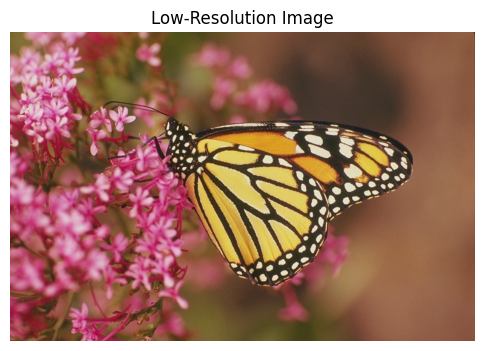

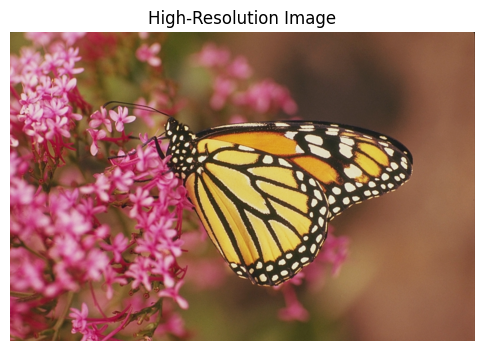

finish


In [5]:
%run GlobalConfig.ipynb
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import math
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bicubic_interpolation(img, scale_factor):
    width, height = img.size
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    img_np = np.array(img)
    img_np = cv2.resize(img_np, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
    img = Image.fromarray(img_np)
    return img
    
# 读取 PFM 文件中的权重
def read_pfm(file):
    with open(file, 'rb') as f:
        header = f.readline().decode('ascii').rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        dim_line = f.readline().decode('ascii').rstrip()
        width, height = map(int, dim_line.split())

        scale_line = f.readline().decode('ascii').rstrip()
        scale = float(scale_line)
        if scale < 0:
            endian = '<'
            scale = -scale
        else:
            endian = '>'

        data = np.frombuffer(f.read(), dtype=endian + 'f')
        data = np.reshape(data, (height, width, 3) if color else (height, width))
        data = np.flipud(data)

        return data, scale
        
# 从 PFM 文件加载 3D LUT
def load_lut(lut_size=global_lut_size):
    lut = np.zeros((lut_size[0], lut_size[1], lut_size[2]), dtype=np.float32)
    for i in range(lut_size[2]):
        file_name = f'Luts/Lut{i}.pfm'
        layer_data, _ = read_pfm(file_name)
        lut[:, :, i] = layer_data
    return torch.tensor(lut, device=device)

# 镜像填充函数
def mirror_pad(image, pad_size):
    return torch.nn.functional.pad(image, (pad_size, pad_size, pad_size, pad_size), mode='reflect')

def apply_lut(lr_image, lut, scale_factor=global_scale_factor, lut_size=global_lut_size):
    lr_image = lr_image.to(device)
    lr_height, lr_width = lr_image.shape[:2]
    hr_height, hr_width = int(lr_height * scale_factor), int(lr_width * scale_factor)

    # 镜像填充LR图像
    pad_size = 2  # 为了计算4x4补丁，填充2个像素
    padded_lr_image = mirror_pad(lr_image.permute(2, 0, 1), pad_size).permute(1, 2, 0)  # 转置到(N, C, H, W)后填充，再转回(H, W, C)

    # 创建高分辨率图像张量
    hr_image = torch.zeros((hr_height, hr_width, 3), device=device)

    # 生成 (i, j) 坐标网格
    i_coords = torch.arange(hr_height, device=device)
    j_coords = torch.arange(hr_width, device=device)
    ii, jj = torch.meshgrid(i_coords, j_coords, indexing='ij')

    # 计算 (x, y) 偏移
    x = ((ii + 0.5) / scale_factor + 0.5) % 1
    y = ((jj + 0.5) / scale_factor + 0.5) % 1

    # 将 (x, y) 坐标输入模型，计算权重
    weights = lut.reshape(lut_size[0], lut_size[1], 4, 4).to(device)

    # 计算 LR 图像中的采样坐标
    x_lr = torch.floor((ii + 0.5) / scale_factor - 1.5 + pad_size).long()  # 加上填充的补偿
    y_lr = torch.floor((jj + 0.5) / scale_factor - 1.5 + pad_size).long()  # 加上填充的补偿

    # 应用权重到 LR 图像的 4x4 补丁上
    # for dx in range(4):
    #     for dy in range(4):
    #         xi = torch.clamp(x_lr + dx, 0, lr_height - 1)
    #         yi = torch.clamp(y_lr + dy, 0, lr_width - 1)
    #         hr_image += weights[:, :, dx, dy].unsqueeze(-1) * lr_image[xi, yi].unsqueeze(2)

    
    # 对每个通道独立进行计算
    for c in range(3):
        hr_image_channel = hr_image[:, :, c]
        lr_image_channel = padded_lr_image[:, :, c]
        for dx in range(4):
            for dy in range(4):
                # xi = torch.clamp(x_lr + dx, 0, lr_height - 1)
                # yi = torch.clamp(y_lr + dy, 0, lr_width - 1)
                xi = x_lr + dx
                yi = y_lr + dy
                hr_image_channel += (weights[torch.floor(x*(lut_size[0]-1)).long(), torch.floor(y*(lut_size[1]-1)).long(), dx, dy] * lr_image_channel[xi, yi])
    
    hr_image = hr_image.clamp(0, 1)  # 确保值在 [0, 1] 范围内
    return hr_image

# 文件路径
lr_image_path = 'G:/Data/Test/'

lr_image_name = '1.png'
# 读取 LR 图像
lr_image = Image.open(lr_image_path + lr_image_name).convert('RGB')

# 可视化 LR 图像
plt.figure(figsize=(6, 6))
plt.imshow(lr_image)
plt.title('Low-Resolution Image')
plt.axis('off')
plt.show()

# 转换为 PyTorch 张量并移到 GPU
to_tensor = ToTensor()
lr_tensor = to_tensor(lr_image).unsqueeze(0).to(device)

lut = load_lut()
# 应用 LUT
hr_image = apply_lut(lr_tensor.squeeze().permute(1, 2, 0).to(device), lut).cpu().detach().numpy()

# 可视化 HR 图像
plt.figure(figsize=(6, 6))
plt.imshow(hr_image)
plt.title('High-Resolution Image')
plt.axis('off')
plt.show()

# 将 float32 类型转换为 uint8 类型，范围在 0 到 255
uint8_image = (hr_image * 255).astype(np.uint8)

# 将 hr_image 转换为 PIL 图像
hr_image_pil = Image.fromarray(uint8_image)

# 保存 HR 图像到文件
hr_image_pil.save(lr_image_path+'SR_'+ lr_image_name)

# 双三次插值超采样
img_bicubic = bicubic_interpolation(Image.open(lr_image_path + lr_image_name), scale_factor=global_scale_factor)
img_bicubic.show()

# 保存超采样后的图像
img_bicubic.save(lr_image_path+'SR_LANCZOS4_'+ lr_image_name)

lr_image.close()

print('finish')
